# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
  1
 -1
  1
 -1
 -1
 -1
 -1
  1
  1
  ⋮
 -1
 -1
 -1
 -1
 -1
 -1
 -1
  1
 -1

### We create a function to visualize the data

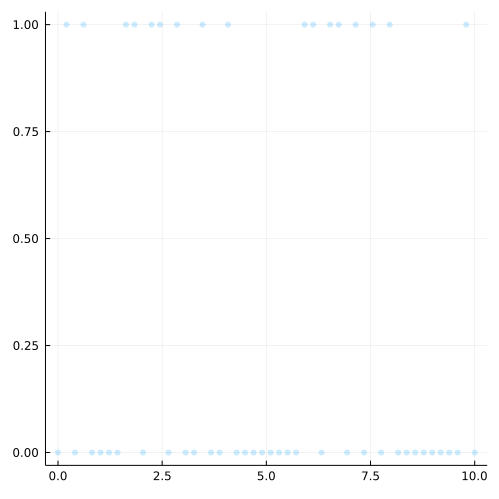

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.023211 seconds (1.85 M allocations: 98.305 MiB, 99.68% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.8066845037112695, 0.7921467201906501, 0.7839936676565823, 0.7749235465321543, 0.7574423626341563, 0.7272913767120807, 0.6869802413928937, 0.6455095370769179, 0.6144170660215473, 0.6005444645385701  …  1.010609148833218, 1.1604366757609885, 1.279729329758144, 1.3540326614667975, 1.3770185885302748, 1.3505914189972774, 1.2843199038511661, 1.1939090536330066, 1.098435103034566, 1.016680220138962], θ = [0.2372706325905135, 0.23769849987672206, 0.23793585269032433, 0.238197681447322, 0.2386956349064366, 0.2395334362851303, 0.24061074849511876, 0.24166619686414978, 0.24242122030804775, 0.242747822782521  …  0.2306918990322053, 0.22527041544790657, 0.22067455380637524, 0.2177112453925161, 0.2167812026142248, 0.21784997076777401, 0.2204935246284298, 0.2240032148439194, 0.227566267257427, 0.23

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:11
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:38
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:45
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:18
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:03
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:52
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:34
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:31
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:28
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:25
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-1.584398131096489, -1.703005009507252, -1.7239282132632177, -1.5618032006594447, -1.2968077328684442, -0.8584925831119936, -0.4114986201664824, 0.003419919289191886, 0.35055022997571383, 0.5067404318828155  …  0.24936337967716815, -0.11025054378204668, -0.4968850896781181, -0.896996301948739, -1.181093802038252, -1.3321466772145185, -1.296212836827289, -1.164143250046331, -0.8616089486843483, -0.5747967970743465]]
 [[-0.3084219223220972, -0.33174733345482454, -0.3286629827172094, -0.278682161130343, -0.25978230069275293, -0.23857840081305465, -0.2605046396193918, -0.287905164258284, -0.31831862842674175, -0.3620976821525536  …  -1.3590037808197601, -1.4335682027331356, -1.4270541523378948, -1.3656622217271348, -1.2304796999004755, -0.9935728692090581, -0.7471392441672986, -0.4954992491022655, -0.2871890051756151, -0.19233102193367146]]
 [[-0.5665238784503306, -0.5374314765205557, -0.45388443925486455, -0.340781136191782, -0.213566776046

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

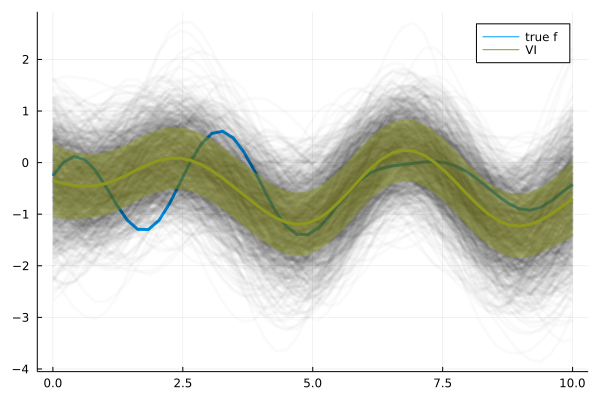

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

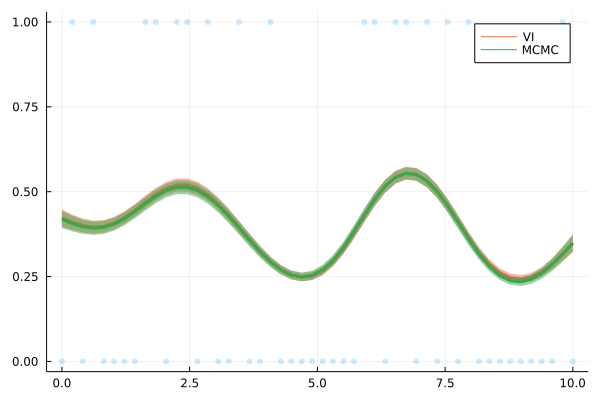

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*